In [1]:
import olympe
import os
from olympe.messages.ardrone3.Piloting import TakeOff, Landing, moveBy
import olympe
from olympe.messages.ardrone3.Piloting import TakeOff, Landing, moveBy, PCMD, moveTo
from olympe.messages.ardrone3.PilotingState import FlyingStateChanged, PositionChanged, GpsLocationChanged, moveToChanged
from olympe.enums.ardrone3.PilotingState import FlyingStateChanged_State as FlyingState
from olympe.messages.ardrone3.GPSSettingsState import GPSFixStateChanged, HomeChanged
from olympe.messages.ardrone3.PilotingState import (
    PositionChanged,
    SpeedChanged,
    AttitudeChanged,
    AltitudeAboveGroundChanged,
    AlertStateChanged,
    FlyingStateChanged,
    NavigateHomeStateChanged,
)
from olympe.media import (
    media_created,
    resource_created,
    media_removed,
    resource_removed,
    resource_downloaded,
    indexing_state,
    delete_media,
    download_media,
    download_media_thumbnail,
    MediaEvent,
)
from olympe.messages.gimbal import set_target, attitude
from olympe.messages.camera import (
    set_camera_mode,
    set_photo_mode,
    take_photo,
    photo_progress,
)
# olympe.log.update_config({"loggers": {"olympe": {"level": "INFO"}}})
olympe.log.update_config({
    "loggers": {
        "olympe": {
                "handlers": []
            }
        },
        "ulog": {
            "level": "OFF",
            "handlers": [],
        }
})
import requests
from io import BytesIO
from PIL import Image
from collections import OrderedDict

DRONE_IP = os.environ.get("DRONE_IP", "10.202.0.1")
ANAFI_URL = "http://{}/".format(DRONE_IP)
ANAFI_MEDIA_API_URL = ANAFI_URL + "api/v1/media/medias/"
img = None

In [9]:
class FlightListener(olympe.EventListener):

    # This set a default queue size for every listener method
    default_queue_size = 100

    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        self.takeoff_count = 0

    @olympe.listen_event(
        FlyingStateChanged(state="landed")
        >> TakeOff()
    )
    def onTakeOff(self, event, scheduler):
        # This method will be called once for each completed sequence of event
        # FlyingStateChanged: takeoff command >> takingoff -> hovering
        print("The drone has taken off!")
        self.takeoff_count += 1
    
    @olympe.listen_event(PositionChanged(_policy="wait"))
    def onPositionChanged(self, event, scheduler):
        print(
            "latitude = {latitude} longitude = {longitude} altitude = {altitude}".format(
                **event.args
            )
        )
    
#     @olympe.listen_event(resource_created())
#     def onResourceCreated(self, event, scheduler):
#         print("a resource has been created")
    
    @olympe.listen_event(media_created())
    def onMediaCreated(self, event, scheduler):
        print("a media has been created")
#         print(type(event))
#         media_info_response = requests.get(ANAFI_MEDIA_API_URL + event.media_id)
#         media_info_response.raise_for_status()
#         resource = media_info_response.json()["resources"][0]
#         print("resource url", resource["url"])
#         print("resource url from event:", event.data.resources[0].url)
#         print("resource id", event.resource_id)
#         print(type(event.media))
#         print("media", list(event.media.resources.items()))
#         print("media", list(event.media.resources.values())[0])
#         print("media", list(event.media.resources.values())[0].url)
#         print("media type", type(list(event.media.resources.values())[0].url))
#         print("media type", type(str(list(event.media.resources.values())[0].url)))
        anafi_url = list(event.media.resources.values())[0].url
        
#         print("media url", event.media.resources[0]["url"])
#         print("media url 2", event.media.resources[0].url)


#         print("media", event.media.MediaInfo["resources"][0])
#         print("data", event.data)
        image_response = requests.get(ANAFI_URL + anafi_url, stream=True)
        image_response.raise_for_status()
        global img
        img = Image.open(BytesIO(image_response.content))
        display(img)

In [12]:
def take_single_photo(drone):
    photo_saved = drone(photo_progress(result="photo_saved", _policy="wait"))
    drone(take_photo(cam_id=0)).wait()
    if not photo_saved.wait(_timeout=30).success():
        assert False, "take_photo timedout"

def setup_camera(drone):
    drone(set_camera_mode(cam_id=0, value="photo")).wait()

    assert drone(
        set_photo_mode(
            cam_id=0,
            mode="single",
            format= "rectilinear",
            file_format="jpeg",
            # the following are ignored in photo single mode
            burst="burst_14_over_1s",
            bracketing="preset_1ev",
            capture_interval=5.0,
        )
    ).wait().success()
    
    pitch = -90.0
    assert drone(
        set_target(
            gimbal_id=0,
            control_mode="position",
            yaw_frame_of_reference="none",
            yaw=0.0,
            pitch_frame_of_reference="absolute",
            pitch=pitch,
            roll_frame_of_reference="none",
            roll=0.0,
            )
        >> attitude(
            pitch_absolute=pitch, _policy="wait", _float_tol=(1e-3, 1e-1)
            )
        ).wait(_timeout=20).success()

def success_if_takeoff(drone):
    return drone(
                FlyingStateChanged(state="hovering")
                | (TakeOff() & FlyingStateChanged(state="hovering"))
            ).wait(5).success()
    
def start():
    drone = olympe.Drone(DRONE_IP)
    assert drone.connect()
    with FlightListener(drone) as flight_listener:
        takeoff_success = success_if_takeoff(drone)
        if not takeoff_success:
            print("Retrying taking off...")
            takeoff_success = success_if_takeoff(drone)
            
        assert drone.media_autoconnect
        media = drone.media
        media.integrity_check = True
        assert media(
            indexing_state(state="indexed")
        ).wait(_timeout=60).success()
    
        setup_camera(drone)
    
#         drone(moveBy(5, 0, 0, 0)).wait().success()
#         drone(moveBy(-5, 0, 0, 0)).wait().success()

        home = drone.get_state(GpsLocationChanged)
        home_lat = home["latitude"]
        home_long = home["longitude"]
        home_alt = home["altitude"]
    
        drone(
            moveTo(
                home_lat,  
                home_long, 
                6.5, 
                "HEADING_DURING", 90.0)
            >> moveToChanged(status="DONE", _timeout=15)
        ).wait()

        take_single_photo(drone)
        
        drone(
            moveTo(
                home_lat,  
                home_long + 6.8e-5, 
                6.5, 
                "HEADING_DURING", 90.0)
            >> moveToChanged(status="DONE", _timeout=15)
        ).wait()
        
        take_single_photo(drone)
                
        drone(
            moveTo(
                home_lat + 7.2e-5,  
                home_long + 6.8e-5, 
                6.5, 
                "HEADING_DURING", 90.0)
            >> moveToChanged(status="DONE", _timeout=15)
        ).wait()
        
        take_single_photo(drone)
        
        drone(Landing()).wait()
        assert drone(FlyingStateChanged(state="landed")).wait().success()
    drone.disconnect()

541 Server Error: Media Not Yet Indexed for url: http://10.202.0.1:80/api/v1/media/medias
Media are not yet indexed


latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
The drone has taken off!
latitude = 48.87889999990942 longitude = 2.3677785069898754 altitude = 0.003912732936441898
latitude = 48.878899989634455 longitude = 2.3677789737078294 altitude = 0.24301740527153015
latitude = 48.87889999581351 longitude = 2.367778663237253 altitude = 0.8448071479797363
latitude = 48.878900065385075 longitude = 2.3677786667230687 altitude = 0.8992602229118347
latitude = 48.878900152308354 longitude = 2.3677785701750893 altitude = 0.9219933748245239
latitude = 48.87890004540276 longitude = 2.367778482964654 altitude = 0.9499443173408508
latitude = 48.87890004222328 longitude = 2.367778512438485 altitude = 0.9646264910697937
latitude = 48.87890015059791 longitude = 2.367778516496561 altitude = 0.9707322120666504
latitude = 48.87890016311719 longitude = 2.3677785999767784 altitude = 0.9808418154716492
latitude = 48.878900165719394 longitude = 2.3677787010206957 altitude = 0.9811091423034668
latitu

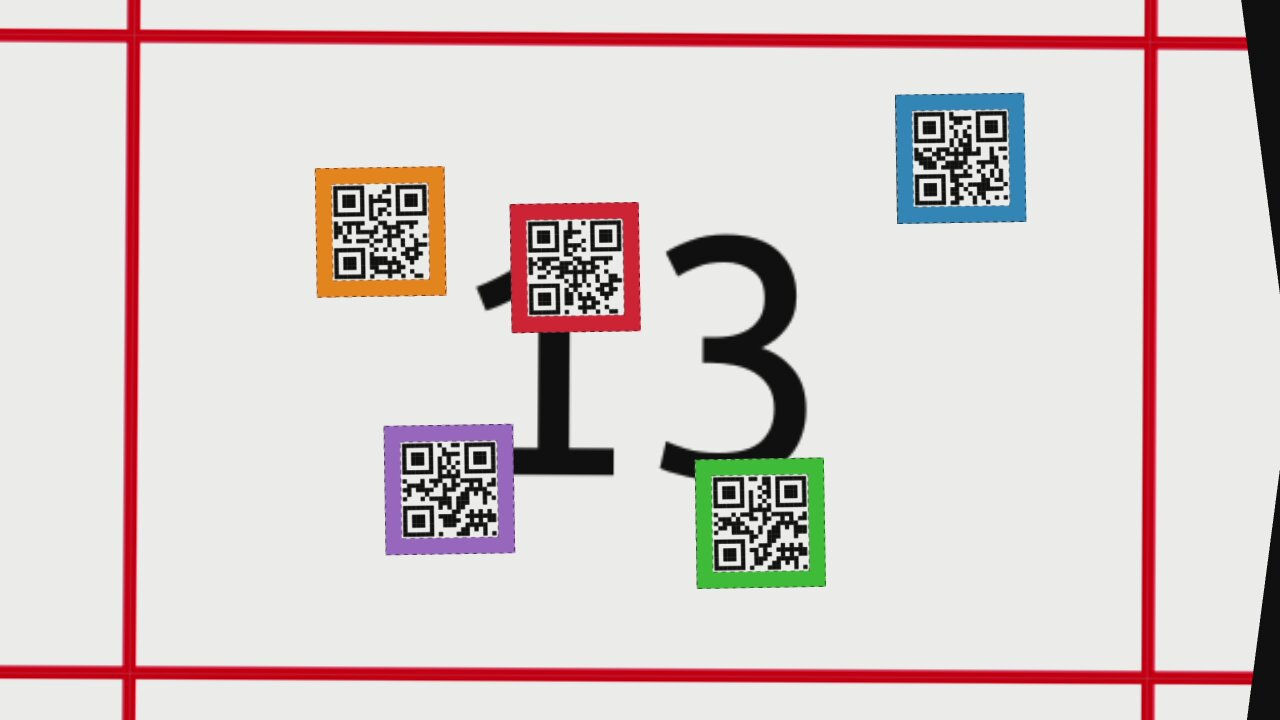

latitude = 48.878900165235684 longitude = 2.3677790548649185 altitude = 6.23830509185791
latitude = 48.87890015826891 longitude = 2.3677903652245558 altitude = 6.204282760620117
latitude = 48.87890011889973 longitude = 2.367797259478638 altitude = 6.227010726928711
latitude = 48.878900139010575 longitude = 2.367809539413425 altitude = 6.217682838439941
latitude = 48.878900157708465 longitude = 2.36782084113386 altitude = 6.266087532043457
latitude = 48.878900159945296 longitude = 2.367824382815101 altitude = 6.285899639129639
latitude = 48.878900225941386 longitude = 2.3678340334802237 altitude = 6.353294849395752
latitude = 48.87890023202099 longitude = 2.367841506338538 altitude = 6.436193466186523
latitude = 48.878900228066904 longitude = 2.367844997142689 altitude = 6.515748977661133
a media has been created


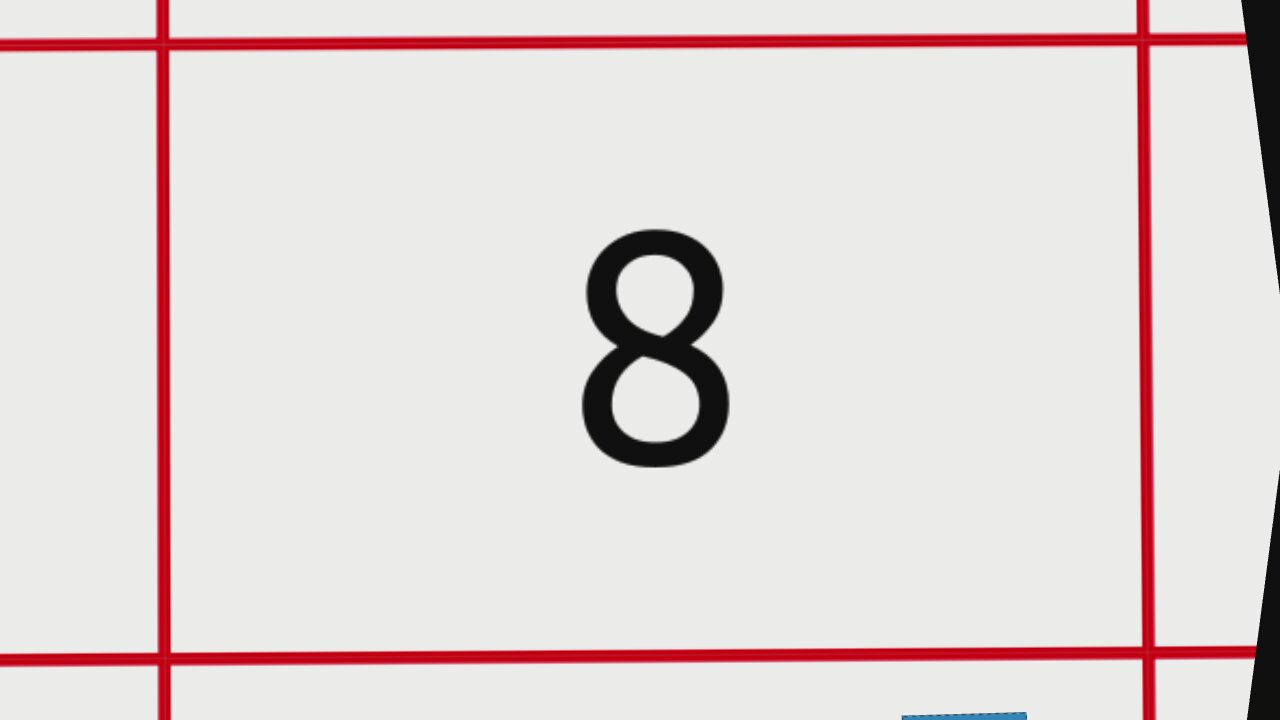

latitude = 48.8789045585116 longitude = 2.3678463561103604 altitude = 6.550991535186768
latitude = 48.87892676130317 longitude = 2.367847220978511 altitude = 6.590342044830322
latitude = 48.878930300363514 longitude = 2.3678472736129064 altitude = 6.6011738777160645
latitude = 48.878944320342576 longitude = 2.367847101775167 altitude = 6.638789653778076
latitude = 48.878950266276966 longitude = 2.3678468555502645 altitude = 6.659937858581543
latitude = 48.87896256713824 longitude = 2.3678465468513594 altitude = 6.700620651245117
latitude = 48.87896873424719 longitude = 2.3678464435648348 altitude = 6.728092670440674
latitude = 48.878971329770444 longitude = 2.3678465345339195 altitude = 6.746160507202148
a media has been created


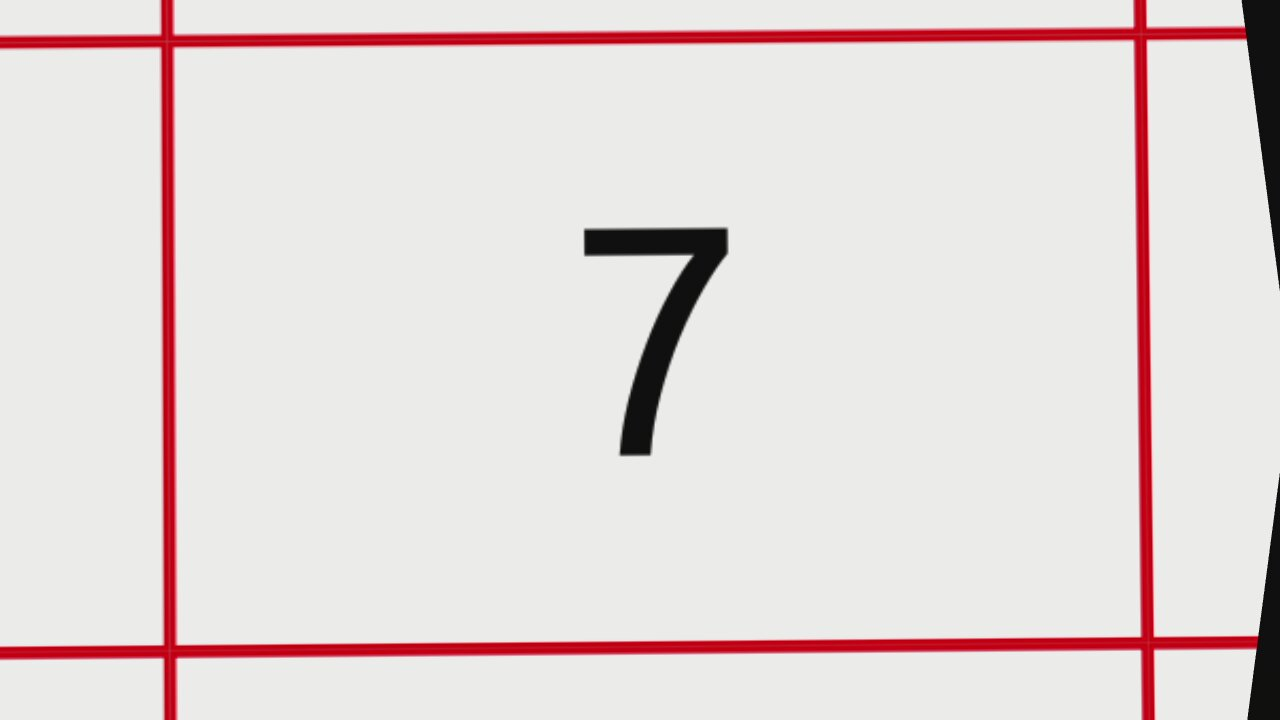

latitude = 48.8789720949247 longitude = 2.3678466508616722 altitude = 5.867961406707764
latitude = 48.87897218826068 longitude = 2.3678467590190957 altitude = 4.434621810913086
latitude = 48.87897286888286 longitude = 2.3678467829367076 altitude = 3.0704188346862793
latitude = 48.87897310881484 longitude = 2.3678468047677232 altitude = 1.8584342002868652
latitude = 48.878973167160744 longitude = 2.367846815135499 altitude = 1.1288286447525024
latitude = 48.87897316482516 longitude = 2.3678468332888882 altitude = 0.646919846534729
latitude = 48.87897316666598 longitude = 2.3678469999949043 altitude = 0.45928245782852173
latitude = 48.87897316666598 longitude = 2.3678469999949043 altitude = 0.3353917896747589
latitude = 48.87897316666598 longitude = 2.3678469999949043 altitude = 0.24492041766643524


In [14]:
start()

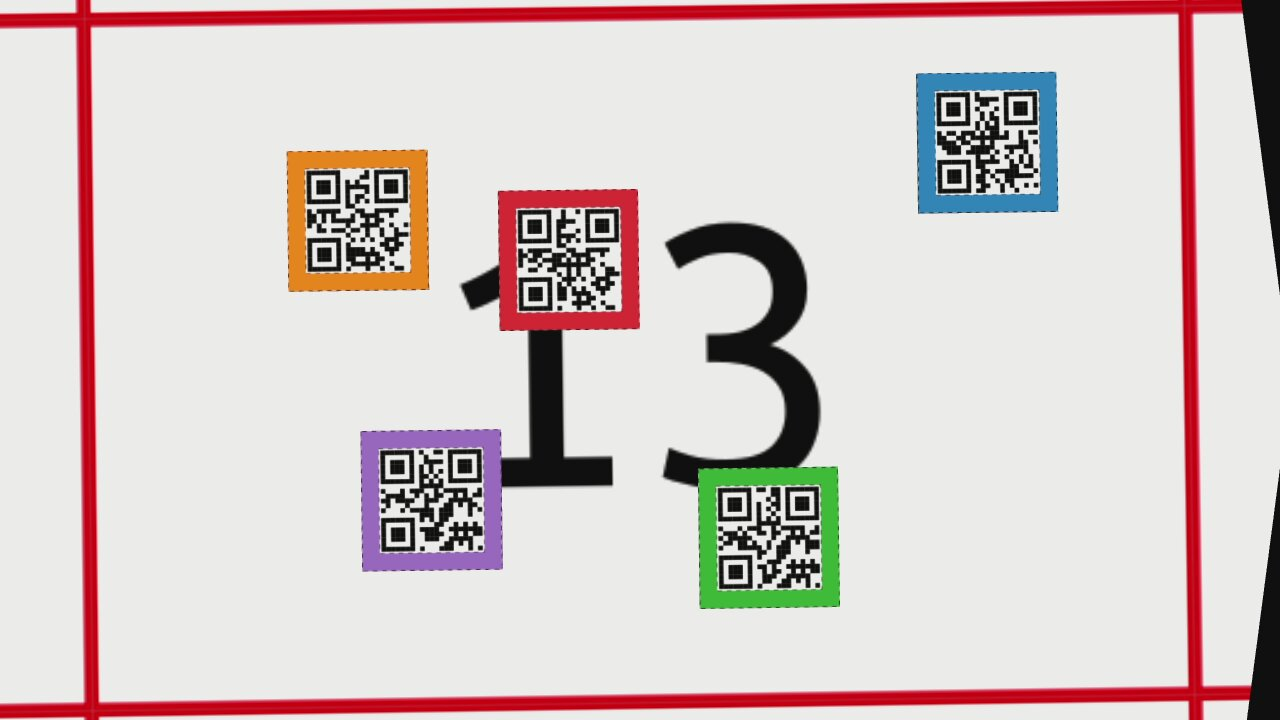

In [8]:
display(img)

In [29]:
data = {"media": {'media_id': '10000001', 'type': 'PHOTO', 'datetime': '19700101T000021+0000', 'size': 38834, 'run_id': '17BE8118D254796730330FFEB3A9C72D', 'gps': {'latitude': 48.8789, 'longitude': 2.367779, 'altitude': 0.991773}, 'thumbnail': '/data/thumbnails/100000010001.JPG', 'resources': [{'media_id': '10000001', 'resource_id': '100000010001.JPG', 'type': 'PHOTO', 'format': 'JPG', 'datetime': '19700101T000021+0000', 'size': 38834, 'url': '/data/media/100000010001.JPG', 'storage': 'removable_storage', 'gps': {'latitude': 48.8789, 'longitude': 2.367779, 'altitude': 0.991773}, 'width': 1280, 'height': 720, 'thumbnail': '/data/thumbnails/100000010001.JPG', 'md5': ''}], 'photo_mode': 'SINGLE'}}

In [36]:
data['media']['resources'][0]["url"]

'/data/media/100000010001.JPG'

In [37]:
mediainfo = OrderedDict([('100000010001.JPG', ResourceInfo(media_id='10000001', resource_id='100000010001.JPG', type='PHOTO', format=<ResourceFormat.jpg: 'JPG'>, datetime='19700101T000021+0000', size=38834, url='/data/media/100000010001.JPG', width=1280, height=720, duration=None, thumbnail='/data/thumbnails/100000010001.JPG', signature=None, gps=GPS(latitude=48.8789, longitude=2.367779, altitude=0.991773), video_mode=None, replay_url=None, thermal=None, md5='', storage='removable_storage', download_path=None, thumbnail_download_path=None))])

SyntaxError: invalid syntax (1225511492.py, line 1)

In [47]:
media = OrderedDict([('100000010001.JPG', ResourceInfo(media_id='10000001', resource_id='100000010001.JPG', type='PHOTO', format=<ResourceFormat.jpg: 'JPG'>, datetime='19700101T000023+0000', size=25724, url='/data/media/100000010001.JPG', width=1280, height=720, duration=None, thumbnail='/data/thumbnails/100000010001.JPG', signature=None, gps=GPS(latitude=48.8789, longitude=2.367779, altitude=0.0), video_mode=None, replay_url=None, thermal=None, md5='', storage='removable_storage', download_path=None, thumbnail_download_path=None))])


SyntaxError: invalid syntax (2319853422.py, line 1)

# SIDEWAYS
TRY 1
=====
latitude = 48.87890000000001 longitude = 2.3677786666666667 altitude = 0.0
The drone has taken off!
latitude = 48.87890000030853 longitude = 2.3677787242798187 altitude = 0.015895582735538483
latitude = 48.87890000030853 longitude = 2.3677787242798187 altitude = 0.015895582735538483
latitude = 48.87889999986842 longitude = 2.367778897542681 altitude = 0.07241345942020416
latitude = 48.87889999875063 longitude = 2.3677791542583093 altitude = 0.3162614703178406
latitude = 48.87889999989014 longitude = 2.367778929962817 altitude = 0.7051576375961304
latitude = 48.878900001413044 longitude = 2.367778754326833 altitude = 0.8368930816650391
Retrying taking off...
latitude = 48.878894354495365 longitude = 2.367779131859542 altitude = 0.8935615420341492
latitude = 48.878870010983825 longitude = 2.367780718618901 altitude = 0.8955569267272949
latitude = 48.8788495483171 longitude = 2.3677823305217984 altitude = 0.9271961450576782
latitude = 48.87883716696191 longitude = 2.3677832576357294 altitude = 0.9491897821426392

TRY 2
=====
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
Retrying taking off...
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
The drone has taken off!
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.878899994387034 longitude = 2.3677786887417938 altitude = 0.7499155402183533
latitude = 48.87889739445162 longitude = 2.3677786912952636 altitude = 0.8819987773895264
latitude = 48.878875525801355 longitude = 2.3677792853227735 altitude = 0.8728868961334229
latitude = 48.87885408413816 longitude = 2.367779496364583 altitude = 0.8999571800231934
latitude = 48.87884030023664 longitude = 2.367779659930312 altitude = 0.9303063750267029
latitude = 48.878832933475074 longitude = 2.367779792313752 altitude = 0.9503011703491211
latitude = 48.878829537698344 longitude = 2.367779856321525 altitude = 0.9625056982040405
latitude = 48.878824465584636 longitude = 2.3677800073542263 altitude = 0.9803971648216248
latitude = 48.878800730210365 longitude = 2.367780357343696 altitude = 0.9544368386268616
latitude = 48.878780426177705 longitude = 2.3677808642179152 altitude = 0.9634929299354553
latitude = 48.87876744628405 longitude = 2.367781240170636 altitude = 0.9772684574127197
latitude = 48.87876092900509 longitude = 2.3677813752286485 altitude = 0.9818578362464905
latitude = 48.878758029652396 longitude = 2.3677814266367614 altitude = 0.985541045665741
latitude = 48.878757093032924 longitude = 2.367781498087815 altitude = 0.5912613272666931
latitude = 48.878756921931505 longitude = 2.3677813801612895 altitude = 0.2667687237262726
latitude = 48.87875583334638 longitude = 2.367781499999985 altitude = 0.08288989961147308
latitude = 48.87875583334638 longitude = 2.367781499999985 altitude = 0.07309550046920776
latitude = 48.87875583334638 longitude = 2.367781499999985 altitude = 0.060530491173267365
latitude = 48.87875583334638 longitude = 2.367781499999985 altitude = 0.041508905589580536

TRY 3
=====
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
Retrying taking off...
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
The drone has taken off!
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.878899995443405 longitude = 2.3677787498326874 altitude = 0.7030233144760132
latitude = 48.87890008932335 longitude = 2.3677786861988945 altitude = 0.8743911385536194
latitude = 48.87890245111097 longitude = 2.36777858566852 altitude = 0.8902562260627747
latitude = 48.87892153335482 longitude = 2.3677777451773983 altitude = 0.889750063419342
latitude = 48.878944578075185 longitude = 2.367777352955542 altitude = 0.9202186465263367
latitude = 48.87895969236737 longitude = 2.3677772009324203 altitude = 0.9461658000946045
latitude = 48.87896713147742 longitude = 2.3677770039531296 altitude = 0.9608637690544128
latitude = 48.87897060274221 longitude = 2.367776869228178 altitude = 0.9709508419036865
latitude = 48.87897875956363 longitude = 2.3677767021438645 altitude = 0.9802840352058411
latitude = 48.878998393960806 longitude = 2.367776232466284 altitude = 0.9612684845924377
latitude = 48.87901923375133 longitude = 2.367775626659884 altitude = 0.969992458820343
latitude = 48.87903226048032 longitude = 2.3677752394462668 altitude = 0.9817299246788025
latitude = 48.879038899486055 longitude = 2.367775042601769 altitude = 0.9866944551467896
latitude = 48.879041744778384 longitude = 2.3677749868847533 altitude = 0.9888806343078613
latitude = 48.87904272019326 longitude = 2.3677750067269816 altitude = 0.7357462644577026
latitude = 48.87904287720843 longitude = 2.3677750573436547 altitude = 0.5746821165084839
latitude = 48.879042880686335 longitude = 2.3677750607192953 altitude = 0.5618025660514832
latitude = 48.87904305705555 longitude = 2.367775053482229 altitude = 0.2091279923915863
latitude = 48.87904308026585 longitude = 2.367775051918912 altitude = 0.08521969616413116
latitude = 48.87904399999055 longitude = 2.367775000000153 altitude = 0.08262316137552261
latitude = 48.87904399999055 longitude = 2.367775000000153 altitude = 0.07286027818918228
latitude = 48.87904399999055 longitude = 2.367775000000153 altitude = 0.06425099819898605
latitude = 48.87904399999055 longitude = 2.367775000000153 altitude = 0.04691940173506737

# FORWARD-BACKWARD
TRY 1
=====
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0
The drone has taken off!
latitude = 48.878899999936024 longitude = 2.3677785057545395 altitude = 0.0035104204434901476
latitude = 48.87889999061177 longitude = 2.367778985689967 altitude = 0.3595854640007019
latitude = 48.87889999522752 longitude = 2.367778660591374 altitude = 0.7688604593276978
latitude = 48.87889999484098 longitude = 2.3677785979114057 altitude = 0.8246827721595764
latitude = 48.87890001225921 longitude = 2.3677802903476484 altitude = 0.8854055404663086
latitude = 48.87890002141975 longitude = 2.36778088727827 altitude = 0.8886243104934692
latitude = 48.87890002578254 longitude = 2.36778118224517 altitude = 0.8878068923950195
latitude = 48.87890037083388 longitude = 2.3678043784762752 altitude = 0.9030664563179016
latitude = 48.87890056999944 longitude = 2.367824803437084 altitude = 0.9341332912445068
latitude = 48.87890067893206 longitude = 2.367837555739816 altitude = 0.9541868567466736
latitude = 48.8789007624276 longitude = 2.3678434405091267 altitude = 0.9665444493293762
latitude = 48.878900771042275 longitude = 2.367845943022947 altitude = 0.9764843583106995
latitude = 48.878900876242504 longitude = 2.367864310992513 altitude = 0.9692935943603516
latitude = 48.8789011078131 longitude = 2.3678837920047955 altitude = 0.9714182615280151
latitude = 48.87890113853572 longitude = 2.367886547055473 altitude = 0.9736162424087524
latitude = 48.87890134462642 longitude = 2.3678974336116787 altitude = 0.9819722175598145
latitude = 48.878901401572385 longitude = 2.367900620196586 altitude = 0.9846591949462891
latitude = 48.87890154837097 longitude = 2.3679091361966362 altitude = 0.989862322807312
latitude = 48.87890159919865 longitude = 2.3679126404919373 altitude = 0.992574155330658
latitude = 48.87890158913532 longitude = 2.367913793584265 altitude = 0.5722637176513672
latitude = 48.87890159196919 longitude = 2.3679140703191206 altitude = 0.24763688445091248
latitude = 48.87890149999995 longitude = 2.367914666668389 altitude = 0.08260174840688705
latitude = 48.87890149999995 longitude = 2.367914666668389 altitude = 0.07284139841794968
latitude = 48.87890149999995 longitude = 2.367914666668389 altitude = 0.06423434615135193
latitude = 48.87890149999995 longitude = 2.367914666668389 altitude = 0.04690724238753319

TRY 2
=====
latitude = 48.87890000000001 longitude = 2.3677785 altitude = 0.0018168443348258734
latitude = 48.87890000000001 longitude = 2.367779166666652 altitude = 0.5548354387283325
latitude = 48.87890000000001 longitude = 2.3677789999999637 altitude = 0.6956089735031128
latitude = 48.878899940722704 longitude = 2.367776583668792 altitude = 0.8618418574333191
latitude = 48.87889937571125 longitude = 2.3677523076507123 altitude = 0.9112648963928223
latitude = 48.87889873119487 longitude = 2.3677316856793347 altitude = 0.9316410422325134
latitude = 48.87889837321412 longitude = 2.3677195703818987 altitude = 0.953484833240509
latitude = 48.87889822687881 longitude = 2.3677137218998046 altitude = 0.9657221436500549
latitude = 48.87889813474575 longitude = 2.3677100653416474 altitude = 0.9787122011184692
latitude = 48.878897504340635 longitude = 2.3676857505656494 altitude = 0.9778764247894287
latitude = 48.878896907630256 longitude = 2.367664647263743 altitude = 0.9888181686401367
latitude = 48.878896639815444 longitude = 2.367655199846157 altitude = 0.9903976321220398
latitude = 48.878896472073016 longitude = 2.3676484364306387 altitude = 0.9927974939346313
latitude = 48.87889638507644 longitude = 2.367645136634832 altitude = 0.995128870010376
latitude = 48.87889636918052 longitude = 2.3676441867769995 altitude = 0.5926237106323242
latitude = 48.878896358312964 longitude = 2.367643835589774 altitude = 0.2732008099555969
latitude = 48.87889633333369 longitude = 2.3676431666660727 altitude = 0.08674991130828857
latitude = 48.87889633333369 longitude = 2.3676431666660727 altitude = 0.06334926187992096
latitude = 48.87889633333369 longitude = 2.3676431666660727 altitude = 0.043441880494356155

TRY 3
=====
latitude = 48.878900390235906 longitude = 2.36778991389551 altitude = 1.6156127452850342
latitude = 48.8789011815173 longitude = 2.36781270628584 altitude = 1.4302257299423218
latitude = 48.87890188080845 longitude = 2.3678298675603715 altitude = 1.315893292427063
latitude = 48.87890224768247 longitude = 2.3678395790334794 altitude = 1.246422529220581
latitude = 48.87890243855289 longitude = 2.3678443341977142 altitude = 1.17990243434906
latitude = 48.87890249908727 longitude = 2.3678463577007136 altitude = 0.9659051895141602
latitude = 48.8789024926485 longitude = 2.3678469493747016 altitude = 0.530303418636322
latitude = 48.878902497439036 longitude = 2.3678472105318105 altitude = 0.20224009454250336
latitude = 48.87890249999972 longitude = 2.367847333328012 altitude = 0.15627360343933105
latitude = 48.87890249999972 longitude = 2.367847333328012 altitude = 0.11411906778812408

In [18]:
2.3676431666660727 - 2.3677785

-0.00013533333392734548

In [22]:
2.367914666668389 - 2.3677785

0.00013616666838878189

In [23]:
0.00013616666838878189/2

6.808333419439094e-05

In [24]:
-0.00013533333392734548/2

-6.766666696367274e-05

In [26]:
2.367847333328012 - 2.367785

6.233332801208746e-05

In [27]:
2.367785 + 6.233332801208746e-05

2.367847333328012

In [19]:
48.87889633333369 - 48.87890000000001

-3.66666631634871e-06

In [20]:
2.367775000000153 - 2.3677785

-3.4999998468343563e-06

In [21]:
48.87904399999055 - 48.87890000000001

0.00014399999054148793

Moving along the x-axis (forward-backward) affects the longitude
 - forward causes positive longitudinal change
 - backward causes negative longitudinal change
 - one cell is 6.8e-5 of longitude unit
 
Moving along the y-axis (left-right) affects the lattitude
 - left causes positive lattitudinal change
 - right causes negative lattitudinal change
 - one cell is 7.2e-5 of lattitude unit

In [28]:
48.87904399999055 - 48.87890000000001

0.00014399999054148793

In [29]:
48.87875583334638 - 48.87890000000001

-0.00014416665362659842

In [30]:
print(0.00014399999054148793/2)
print(-0.00014416665362659842/2)

7.199999527074397e-05
-7.208332681329921e-05


In [31]:
48.87883716696191 - 48.87890000000001

-6.283303810050711e-05